In this notebook, we carry out the research of a burn-mapping method.

In [1]:
from gui import GUI
from plot_tools import plot

**TEST**

In [14]:
import sampling
import importlib

importlib.reload(sampling)

from sampling import *

In [12]:
samples.shape

(121, 14)

**Change product**

In [7]:
# change_f = 'test_C11659/pre_post_diff.bin'
img_f = 'test_C11659/0927.bin'
polygon_f = 'polygon_C11659/polygon_0000.bin'

In [901]:
g = GUI(
    polygon_filename=polygon_f,
    image_filename=img_f
)

In [902]:
import matplotlib.pyplot as plt

In [ ]:
g.band_list = [1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]

title, image = g.get_shown_image(band_list=[9, 10, 13])

IMAGE = g.get_band_image()

embed = g.get_band_embed()

running: [1, 2, 4, 5, 6, 8, 9, 10, 13, 14]: pid = 1476245.


/usr/local/lib/python3.12/dist-packages/cuml/internals/api_decorators.py:166: FutureWarning: `n_iter` was deprecated in 25.12 and will be removed in 26.02. Please use `max_iter` instead.
  ret = func(*args, **kwargs)


DONE: [1, 2, 4, 5, 6, 8, 9, 10, 13, 14]: pid = 1476245.


**For the labels**, from index 0 to in_sample_size is all 0 (inside) and the rest is 1

In [904]:
import numpy as np

In [905]:
labels = np.ones(g.in_sample_size + g.out_sample_size)

labels[g.in_sample_size:] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/lib/python3/dist-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


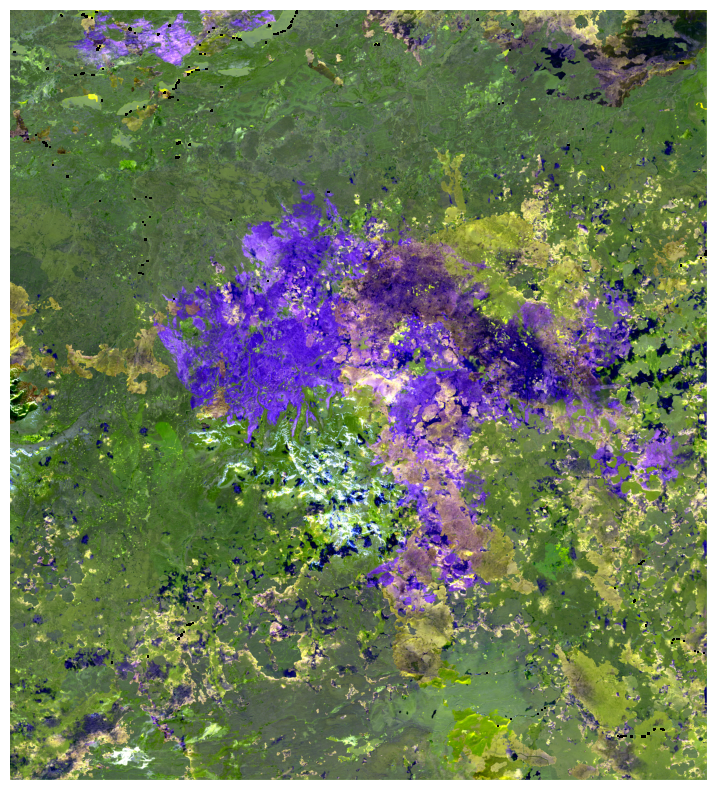

In [906]:
plot(image)

We will be using SVM soft margin linear.

In [907]:
# from cuml.svm import SVC

In [908]:
# clf = SVC(
#     kernel = 'linear',
#     C = 0.1,
#     class_weight = 'balanced'
# )

# clf.fit(embed, labels)

**Get the parameters**

In [909]:
# w = clf.coef_[0]
# b = clf.intercept_[0]
# print("w:", w, "b:", b)

**Now plot the line in the same space**

In [910]:
# xx = np.linspace(embed[:,0].min(), embed[:,0].max(), 200)

# yy = -(w[0]*xx + b) / w[1] # rearrange w0*x + w1*y + b = 0

In [911]:
# fig, (ax_tsne, ax_img) = plt.subplots(1, 2, figsize=(22, 10))

# sc_in = ax_tsne.scatter(
#     embed[:g.in_sample_size, 0], 
#     embed[:g.in_sample_size, 1],
#     s = 5,
#     c='red',
#     label='Inside'
# )

# sc_out = ax_tsne.scatter(
#     embed[g.in_sample_size:, 0], 
#     embed[g.in_sample_size:, 1],
#     s = 5,
#     c='blue',
#     label='Outside'
# )

# ax_tsne.legend()

# img_plot = ax_img.imshow(
#     draw_border(
#         htrim_3d(image),
#         g.border
#     )
# )

# ax_tsne.plot(xx, yy, c = 'green')

# ax_tsne.set_title('Decision Boundary')

# ax_tsne.set_ylim(embed[:,1].min(), embed[:,1].max())

# plt.tight_layout()
# plt.show()

**Classify the rest of the image**

The tsne we are seeing is just the sample, a very tiny part of it. Since we randomly sampled, it could be a pretty good representative of the big picture.

Our current problem is that, TSNE is pretty slow, so we can cheat and learn the tsne embedding without actually using any more tsne.

We can try a Linear Regression model.

Datasets

In [912]:
X = g.samples[..., [b-1 for b in g.band_list]] #Get only the band we need
y1 = embed[:, 0]
y2 = embed[:, 1]

In [913]:
from cuml.neighbors import KNeighborsRegressor

In [ ]:
knn_tsne1 = KNeighborsRegressor(
    n_neighbors=3,
    weights="distance", # important
    algorithm="auto",
    metric="minkowski", # Euclidean
    p=2
)

In [915]:
knn_tsne1.fit(X, y1)

KNeighborsRegressor()

In [ ]:
knn_tsne2 = KNeighborsRegressor(
    n_neighbors=3,
    weights="distance", # important
    algorithm="auto",
    metric="minkowski", # Euclidean
    p=2
)

In [917]:
knn_tsne2.fit(X, y2)

KNeighborsRegressor()

**Input image (all image)**

In [918]:
n_bands = len(g.band_list)

input_img = IMAGE.reshape(-1, n_bands)

input_img = np.nan_to_num(input_img, nan=0.0)

**Approximate TSNE embedding for all Input image**

In [919]:
tsne1 = knn_tsne1.predict(input_img)
tsne2 = knn_tsne2.predict(input_img)

In [920]:
# fig, (ax_tsne, ax_img) = plt.subplots(1, 2, figsize=(20, 12))

# ax_tsne.scatter(
#     tsne1, 
#     tsne2,
#     s = 5
# )

# ax_tsne.legend()

# ax_img.imshow(
#     draw_border(
#         htrim_3d(image),
#         g.border
#     )
# )

# plt.tight_layout()

# ax_tsne.plot(xx, yy)

# ax_tsne.set_ylim(tsne1.min(), tsne1.max())

# plt.show()

As per the classifier, the portion to the right will be classfied as "in the perimeter"

In [921]:
X_tsne = np.column_stack((tsne1, tsne2))

In [922]:
# final_prediction = clf.predict(X_tsne)

In [923]:
# fig = plt.figure(figsize=(10, 10))

# plt.scatter(
#     tsne1, 
#     tsne2, 
# c = final_prediction)

# # plt.plot(xx, yy)

# plt.title('Decision Boundary')

# # plt.ylim(tsne1.min(), tsne1.max())

# plt.tight_layout()

# plt.show()

In [924]:
# plt.figure(figsize=(7, 7))
# plt.imshow(final_prediction.reshape(g.image._ySize, g.image._xSize), cmap='gray')
# plt.axis('off')
# plt.show()

**HDBSCAN**

What if we dont know where the fire was? We just got an image and we need to know the mapping. AKA no labels given.

This algorithm can help.

In [925]:
from cuml.cluster.hdbscan import HDBSCAN
from cuml.cluster.hdbscan import approximate_predict

In [936]:
scan = HDBSCAN(
    min_cluster_size=500, # start here
    min_samples=20, # controls conservativeness
    metric='euclidean'
)

pred = scan.fit_predict(embed)

scan.generate_prediction_data()

In [937]:
np.unique(pred)

array([-1,  0,  1])

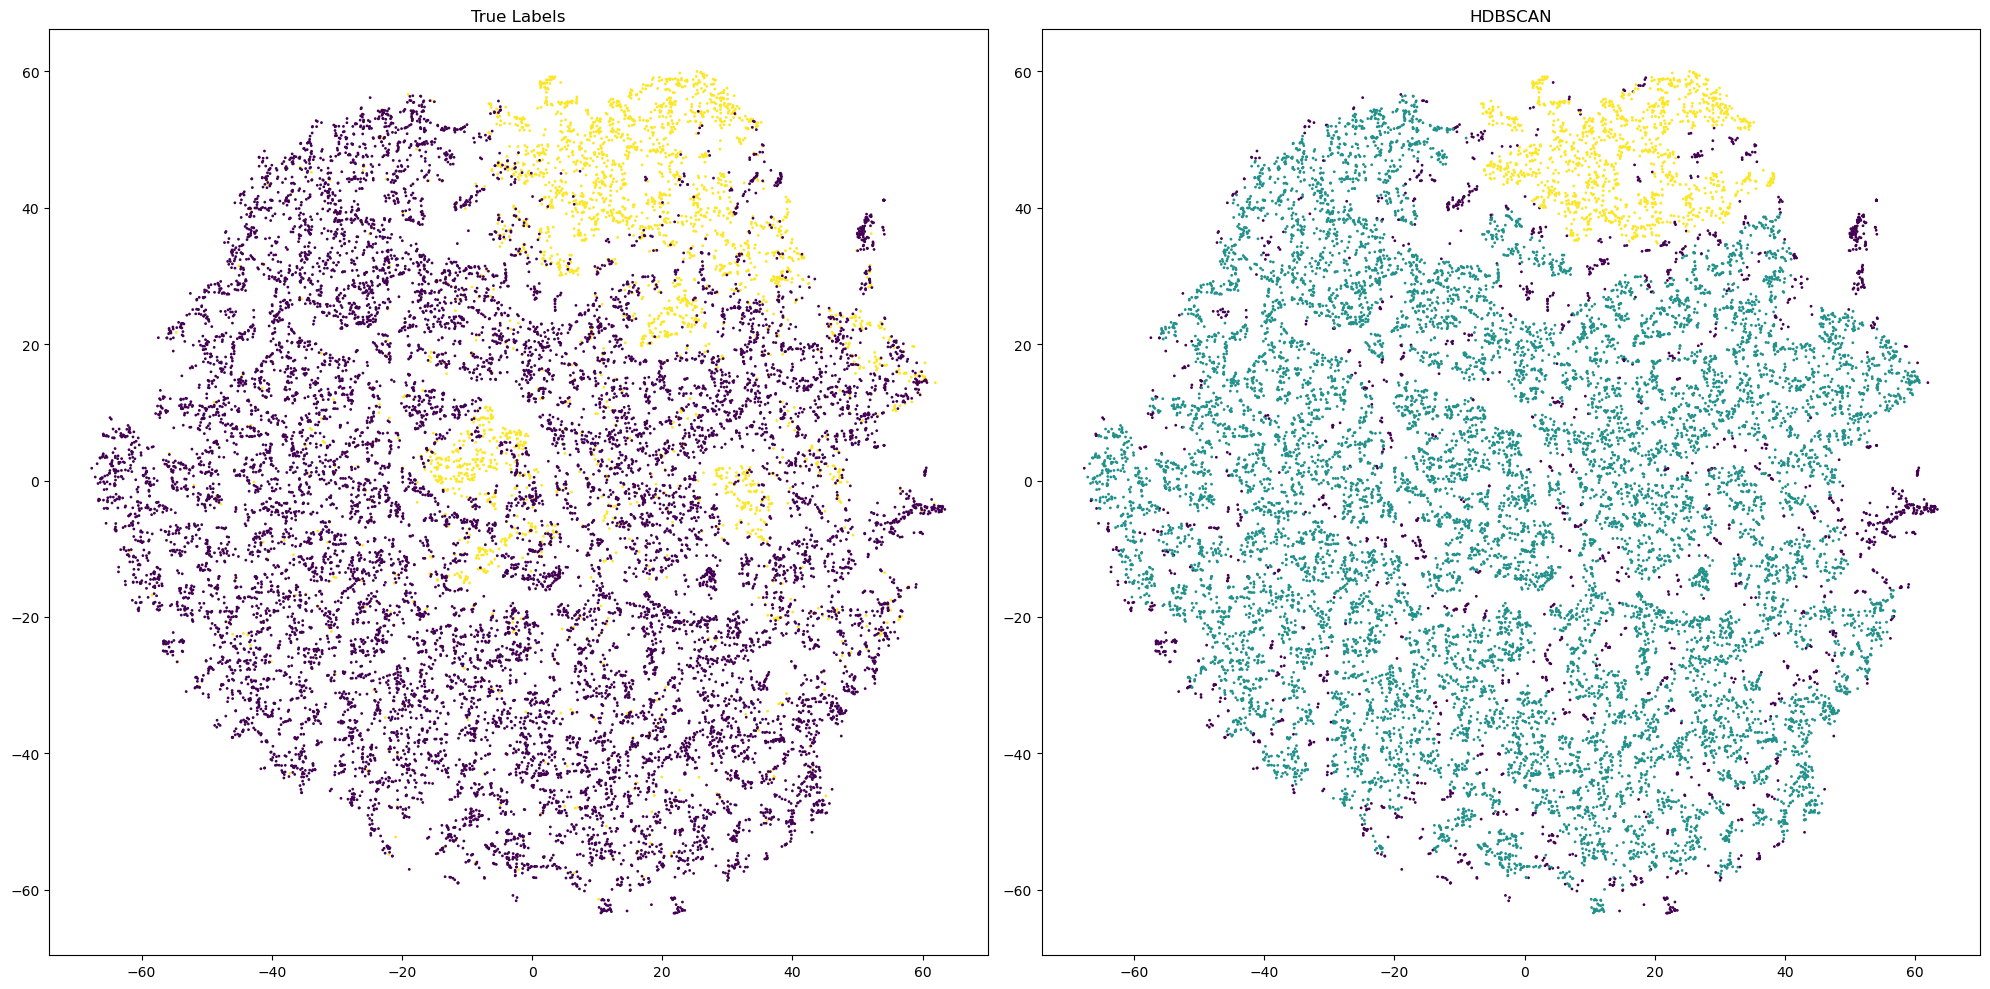

In [938]:
fig, ax_tsne = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))

ax_tsne[0].scatter(
    embed[:, 0], 
    embed[:, 1], 
    c = labels,
    s = 1
)
ax_tsne[0].set_title('True Labels')


ax_tsne[1].scatter(
    embed[:, 0], 
    embed[:, 1], 
    c = pred,
    s = 1
)
ax_tsne[1].set_title('HDBSCAN')

plt.tight_layout()

plt.show()

**Prediction**

In [939]:
new_labels, strengths = approximate_predict(scan, X_tsne)

In [930]:
np.unique(new_labels)

array([-1,  0,  1])

(-0.5, 2707.5, 2991.5, -0.5)

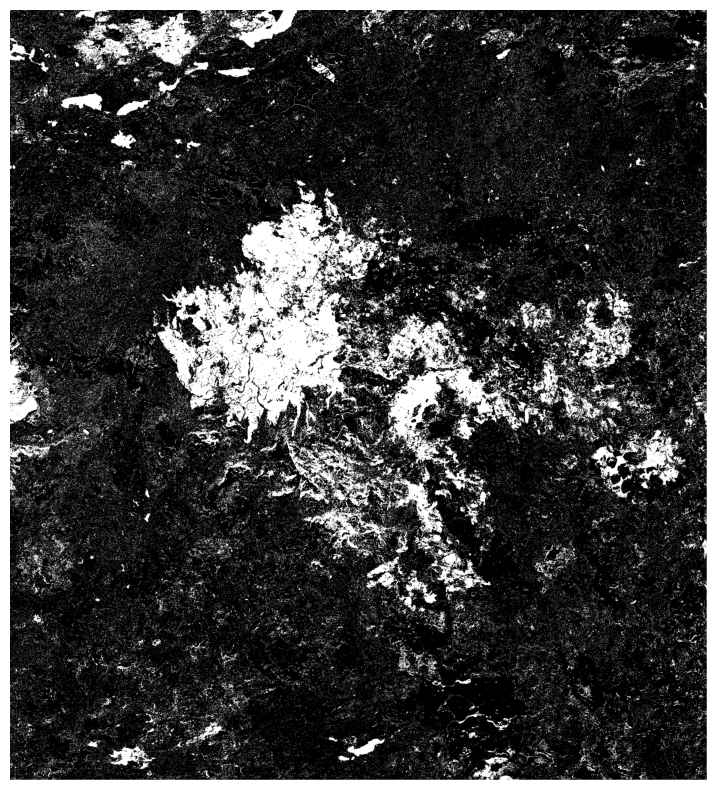

In [940]:
new_labels[new_labels == -1] =  1

plt.figure(figsize=(10,10))
plt.imshow(new_labels.reshape(g.image._ySize, g.image._xSize), cmap='gray')
plt.axis('off')

Features 1, 2, 13 (or 14) are very important